In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!mkdir data
#!unrar x /content/drive/MyDrive/birds_dataset_train.rar /content/data

In [ ]:
#!mkdir data
#!unrar x /content/drive/MyDrive/birds_dataset_validation.rar /content/data

In [ ]:
#!pip install torchmetrics

In [ ]:
import os
import pandas as pd
import glob
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch
from PIL import Image
import numpy as np
import torchvision
from matplotlib.pyplot import figure
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!rm /content/drive/MyDrive/*.png

rm: cannot remove '/content/drive/MyDrive/*.png': No such file or directory


In [ ]:
def yolo_to_pascal_voc(x_center, y_center, w, h,  image_w, image_h):
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w)/2
    y1 = ((2 * y_center * image_h) - h)/2
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

In [ ]:
train_limit=500
valid_limit=10

In [ ]:
!rm /content/drive/MyDrive/rcnn_dataset/data/train/train_labels.csv
!rm /content/drive/MyDrive/rcnn_dataset/data/validation/validation_labels.csv

In [ ]:
os.chdir(r'/content/drive/MyDrive/rcnn_dataset/data/train/annotations')
myFiles = glob.glob('*.txt')

In [ ]:
final_df=[]
k=0
for item in myFiles:
    k+=1
    if k>=train_limit:
      break
    try:
      img=Image.open("/content/drive/MyDrive/rcnn_dataset/data/train/sequences/"+item[0:-3]+'jpg')  
      with open(item, 'rt') as fd:
          for first_line in fd.readlines():
            row=[]
            bbox_temp=[]
            splited = first_line.split();
            row.append(item[0:-3]+'jpg')
            try:
                x1,y1,x2,y2=yolo_to_pascal_voc(float(splited[1]),float(splited[2]),float(splited[3]),float(splited[4]),img.size[0],img.size[1])
                bbox_temp.append(float(x1))
                bbox_temp.append(float(y1))
                bbox_temp.append(float(x2))
                bbox_temp.append(float(y2))
                row.append(bbox_temp)
                final_df.append(row)
                
            except:
                print("file is not in YOLO format!")
    except:
      pass 
df = pd.DataFrame(final_df,columns=['image','bbox'])
df.to_csv("/content/drive/MyDrive/rcnn_dataset/data/train/train_labels.csv",index=False)

In [ ]:
os.chdir(r'/content/drive/MyDrive/rcnn_dataset/data/validation/annotations')
myFiles = glob.glob('*.txt')

In [ ]:
final_df=[]
k=0
for item in myFiles:
    k+=1
    if k>=valid_limit:
      break
    try:
      img=Image.open("/content/drive/MyDrive/rcnn_dataset/data/validation/sequences/"+item[0:-3]+'jpg') 
      with open(item, 'rt') as fd:
          for first_line in fd.readlines():
            row=[]
            bbox_temp=[]
            splited = first_line.split();

            row.append(item[0:-3]+'jpg')
            try:
                x1,y1,x2,y2=yolo_to_pascal_voc(float(splited[1]),float(splited[2]),float(splited[3]),float(splited[4]),img.size[0],img.size[1])
                bbox_temp.append(float(x1))
                bbox_temp.append(float(y1))
                bbox_temp.append(float(x2))
                bbox_temp.append(float(y2))
                row.append(bbox_temp)
                final_df.append(row)
            except:
                print("file is not in YOLO format!")
    except:
      pass
df = pd.DataFrame(final_df,columns=['image','bbox'])
df.to_csv("/content/drive/MyDrive/rcnn_dataset/data/validation/validation_labels.csv",index=False)

In [ ]:
class BirdsDataset(torch.utils.data.Dataset):
  def __init__(self, root, phase):
    self.root = root
    self.phase = phase

    self.targets = pd.read_csv(os.path.join(root, '{}_labels.csv'.format(phase)))
    self.imgs = list(dict.fromkeys(self.targets['image']))
    

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, 'sequences', self.imgs[idx])
    img = Image.open(img_path).convert('RGB')
    img = F.to_tensor(img)
    #
    box_list = self.targets[self.targets['image'] == self.imgs[idx]]

    
    floats = [eval(x) for x in box_list['bbox'].values]
    boxes =torch.tensor(floats, dtype=torch.float32)
    

    #
    labels = torch.ones((len(box_list), ), dtype=torch.int64)
    #
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    #

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
train_dataset = BirdsDataset('/content/drive/MyDrive/rcnn_dataset/data/train', 'train')

valid_dataset = BirdsDataset('/content/drive/MyDrive/rcnn_dataset/data/validation', 'validation')

print("train len :",train_dataset.__len__())
print("Valid len :",valid_dataset.__len__())

#print(train_dataset.__getitem__(1))
#print(valid_dataset.__getitem__(1))


train len : 499
Valid len : 9


In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

In [ ]:
next(iter(train_loader))

((tensor([[[0.1020, 0.1020, 0.1020,  ..., 0.1765, 0.1765, 0.1765],
           [0.1020, 0.1020, 0.1020,  ..., 0.1765, 0.1765, 0.1765],
           [0.1020, 0.1020, 0.1020,  ..., 0.1765, 0.1765, 0.1765],
           ...,
           [0.0980, 0.0941, 0.0941,  ..., 0.0980, 0.0980, 0.0980],
           [0.0980, 0.0941, 0.0941,  ..., 0.0980, 0.0980, 0.0980],
           [0.0980, 0.0941, 0.0941,  ..., 0.0980, 0.0980, 0.0980]],
  
          [[0.1137, 0.1137, 0.1137,  ..., 0.1608, 0.1608, 0.1608],
           [0.1137, 0.1137, 0.1137,  ..., 0.1608, 0.1608, 0.1608],
           [0.1137, 0.1137, 0.1137,  ..., 0.1608, 0.1608, 0.1608],
           ...,
           [0.1451, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
           [0.1451, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
           [0.1451, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412]],
  
          [[0.0706, 0.0706, 0.0706,  ..., 0.1176, 0.1176, 0.1176],
           [0.0706, 0.0706, 0.0706,  ..., 0.1176, 0.1176, 0.1176],
           [0.0706, 0.

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator

#backbone=torchvision.models.mobilenet_v2(pretrained=True).features
#modules = list(backbone.children())[0:1]
#backbone = torch.nn.Sequential(*modules)

#backbone.out_channels=1280


'''anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )'''

    # Feature maps to perform RoI cropping.
    # If backbone returns a Tensor, `featmap_names` is expected to
    # be [0]. We can choose which feature maps to use.
'''roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )'''
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = torchvision.models.detection.FasterRCNN(backbone=backbone,num_classes=2,rpn_anchor_generator=anchor_generator,
#        box_roi_pool=roi_pooler)

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)

model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
'''import torchvision
backbone=torchvision.models.mobilenet_v2(pretrained=True).features
modules = list(backbone.children())[0:3]  # delete the last fc layer.
#backbone_nn = nn.Sequential(*modules)
modules'''

'import torchvision\nbackbone=torchvision.models.mobilenet_v2(pretrained=True).features\nmodules = list(backbone.children())[0:3]  # delete the last fc layer.\n#backbone_nn = nn.Sequential(*modules)\nmodules'

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
metric = MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5])

In [ ]:
import math
def train_one_epoch(model, optimizer, train_dataloader,valid_dataloader):
    
    model.train()
    train_total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_total_loss += losses
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()



    valid_total_loss = 0
    with torch.no_grad():
      for images, targets in valid_dataloader:
          images = [image.to(device) for image in images]
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          valid_total_loss += losses
    
    '''model.eval()    
    train_maps = 0
    with torch.no_grad():
      for images, targets in train_dataloader:
         images = [image.to(device) for image in images]
         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
         pred = model(images, targets)
         metric.update(pred, targets)
         map=metric.compute()['map'].item()
         train_maps+=map

    val_maps = 0
    with torch.no_grad():
      for images, targets in valid_dataloader:
         images = [image.to(device) for image in images]
         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
         pred = model(images, targets)
         metric.update(pred, targets)
         map=metric.compute()['map'].item()
         val_maps+=map'''

    return train_total_loss/len(train_dataloader),valid_total_loss/len(valid_dataloader)#,train_maps/len(train_dataloader),val_maps/len(valid_dataloader)

In [ ]:
num_epochs = 10
train_loss_values=[]
valid_loss_values=[]
train_mAPs=[]
val_mAPs=[]
for epoch in tqdm(range(num_epochs)):
    #train_loss,valid_loss,train_map,val_map = train_one_epoch(model, optimizer, train_loader,valid_loader)
    train_loss,valid_loss = train_one_epoch(model, optimizer, train_loader,valid_loader)

    train_loss_values.append(train_loss.item())
    valid_loss_values.append(valid_loss.item())
    #train_mAPs.append(train_map)
    #val_mAPs.append(val_map)
    print(' epoch [{}]:  \t lr: {}  \ntrain_loss: {} \t valid_loss: {} \t \n\n'.format(epoch, lr_scheduler.get_last_lr(), train_loss,valid_loss))

    #print(' epoch [{}]:  \t lr: {}  \ntrain_loss: {} \t valid_loss: {} \t train_mAP:{} \t val_mAP:{} \n\n'.format(epoch, lr_scheduler.get_last_lr(), train_loss,valid_loss,train_map,val_map))
    lr_scheduler.step()


torch.save(model.state_dict(),'/content/drive/MyDrive/model/model.pt') # Save

 10%|█         | 1/10 [02:51<25:40, 171.20s/it]

 epoch [0]:  	 lr: [0.005]  
train_loss: 0.9445655345916748 	 valid_loss: 1.403616189956665 	 




 20%|██        | 2/10 [05:38<22:32, 169.04s/it]

 epoch [1]:  	 lr: [0.005]  
train_loss: 0.5856483578681946 	 valid_loss: 1.6152652502059937 	 




 30%|███       | 3/10 [08:26<19:40, 168.68s/it]

 epoch [2]:  	 lr: [0.005]  
train_loss: 0.4860480725765228 	 valid_loss: 2.5422205924987793 	 




 40%|████      | 4/10 [11:14<16:49, 168.28s/it]

 epoch [3]:  	 lr: [0.0005]  
train_loss: 0.3534965217113495 	 valid_loss: 2.474836587905884 	 




 50%|█████     | 5/10 [14:02<14:00, 168.08s/it]

 epoch [4]:  	 lr: [0.0005]  
train_loss: 0.33042678236961365 	 valid_loss: 2.764439344406128 	 




 60%|██████    | 6/10 [16:49<11:11, 167.92s/it]

 epoch [5]:  	 lr: [0.0005]  
train_loss: 0.3190670311450958 	 valid_loss: 2.6036949157714844 	 




 70%|███████   | 7/10 [19:38<08:24, 168.04s/it]

 epoch [6]:  	 lr: [5e-05]  
train_loss: 0.3062446117401123 	 valid_loss: 2.6718690395355225 	 




 80%|████████  | 8/10 [22:26<05:35, 168.00s/it]

 epoch [7]:  	 lr: [5e-05]  
train_loss: 0.3039996325969696 	 valid_loss: 2.7108922004699707 	 




 90%|█████████ | 9/10 [25:13<02:47, 167.84s/it]

 epoch [8]:  	 lr: [5e-05]  
train_loss: 0.3022426664829254 	 valid_loss: 2.7427611351013184 	 




100%|██████████| 10/10 [28:00<00:00, 168.07s/it]

 epoch [9]:  	 lr: [5e-06]  
train_loss: 0.3022397756576538 	 valid_loss: 2.6858341693878174 	 




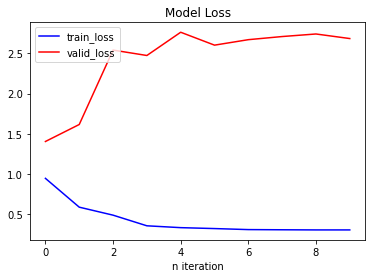

In [ ]:
plt.plot(range(num_epochs), train_loss_values, '-b', label='train_loss')
plt.plot(range(num_epochs), valid_loss_values, '-r', label='valid_loss')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.savefig('/content/drive/MyDrive/model/loss.png', bbox_inches='tight')
plt.show()

#plt.plot(range(num_epochs), train_mAPs, '-b', label='train_mAP')
#plt.plot(range(num_epochs), val_mAPs, '-r', label='val_mAP')
#plt.xlabel("n iteration")

#plt.legend(loc='upper left')
#plt.title('Model mAP')
#plt.savefig('/content/drive/MyDrive/model/mAP.png', bbox_inches='tight')
#plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model/model.pt'))

<All keys matched successfully>

In [ ]:
def evaluate(model, test_dataloader):
    evaluate_maps=0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(figsize=(20, 20))
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=2,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            fig.savefig("/content/drive/MyDrive/output_images/{}.png".format(cnt), dpi=90, bbox_inches='tight')
            plt.clf()
            cnt = cnt + 1
            evaluate_maps+=metric.compute()['map'].item()
            metric.update(out, targets)
        print("mAP (evaluate): ",evaluate_maps/len(test_dataloader))

In [ ]:
!rm /content/drive/MyDrive/output_images/*.*
evaluate(model, valid_loader)

In [ ]:
img,gt=valid_dataset.__getitem__(1)
fig, ax = plt.subplots(figsize=(20, 20))

img=img.permute(1, 2, 0).cpu().numpy()
print(img.shape)
gt=gt['boxes'].cpu().numpy()
w_img,h_img=img.shape[0],img.shape[1]
ax.imshow(img)
window_name = 'Image'
for j in range(len(gt)):
    yolo_bbox1 = (gt[j][0], gt[j][1], gt[j][2], gt[j][3])
    x1, y1, x2, y2=(gt[j][0], gt[j][1], gt[j][2], gt[j][3])
    rect1 = patches.Rectangle((x1,y1),abs(x1-x2),
                               abs(y1-y2),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)